### Autoencoder on MNIST

This notebook is a simple example of an autoencoder on the MNIST dataset. 

An autoencoder is made of 2 parts: an encoder and a decoder. The encoder compresses the input and the decoder tries to reconstruct the input from the compressed version provided by the encoder.

Below we should both the encoder and decoder models. For simplicity of analysis, we use 2-dim latent code. We use 3-layer CNN with MLP for latent code encoding and decoding.

In [15]:
! pip install torch torchvision --upgrade

In [3]:
import torch
import torch
import torch.nn as nn

import torchvision.datasets as datasets
import torchvision.transforms as transforms

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(128*4*4, 2)
        
    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = x.view(-1, 128*4*4)
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(2, 128*4*4)
        self.conv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=0)
        self.conv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv3 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 128, 4, 4)
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))
        return x

# check if the shapes match
tensor = torch.zeros(1, 1, 28, 28)
print(tensor.shape)

encoder = Encoder()
output = encoder(tensor)
print(output.shape)

decoder = Decoder()
output = decoder(output)
print(output.shape)


torch.Size([1, 1, 28, 28])
torch.Size([1, 2])
torch.Size([1, 1, 28, 28])


### Autoencoder Model

Once the encoder and decoder models are defined, we can define the autoencoder model. The autoencoder model takes the input, compresses it into a latent code using the encoder model, then reconstructs the input from the latent code using the decoder model.


In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.bn = nn.BatchNorm1d(2)
        self.decoder = Decoder()
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Autoencoder Training

Once the autoencoder model is defined, we can train it using the MNIST dataset. We use the Adam optimizer and MSE loss function. We train the model for 10 epochs with a batch size of 128.

In [5]:
# Load the MNIST dataset
train_dataset = datasets.MNIST(root='~/data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='~/data', train=False, transform=transforms.ToTensor())

# Create a dataloader for the MNIST dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# Create an instance of the Autoencoder class
autoencoder = Autoencoder()

# Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder.to(device)

# Define the loss function (MSELoss) and the optimizer (Adam)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

# Define the learning rate scheduler (CosineAnnealingLR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

print(f"Number of model parameters: {sum(p.numel() for p in autoencoder.parameters())/1e6:.2f} million")
print(f"Running on: {device}")

# Train the Autoencoder for 10 epochs on the MNIST dataset
num_epochs = 10
for epoch in range(num_epochs):
    for i, (img, _) in enumerate(train_loader):
        img = img.to(device) # Use CUDA if available
        recon = autoencoder(img)
        loss = criterion(recon, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    scheduler.step()
    print('Epoch [{}/{}], Loss: {:.4f}, Learning Rate: {:.6f}'.format(epoch+1, num_epochs, loss.item(), optimizer.param_groups[0]['lr']))


Number of model parameters: 0.20 million
Running on: cuda
Epoch [1/10], Loss: 0.0552, Learning Rate: 0.000976
Epoch [2/10], Loss: 0.0467, Learning Rate: 0.000905
Epoch [3/10], Loss: 0.0454, Learning Rate: 0.000794
Epoch [4/10], Loss: 0.0432, Learning Rate: 0.000655
Epoch [5/10], Loss: 0.0418, Learning Rate: 0.000500
Epoch [6/10], Loss: 0.0429, Learning Rate: 0.000345
Epoch [7/10], Loss: 0.0412, Learning Rate: 0.000206
Epoch [8/10], Loss: 0.0413, Learning Rate: 0.000095
Epoch [9/10], Loss: 0.0408, Learning Rate: 0.000024
Epoch [10/10], Loss: 0.0427, Learning Rate: 0.000000


### Test Autoencoder on Test Split

Sample 16 images from the test split and visualize the reconstructed images.

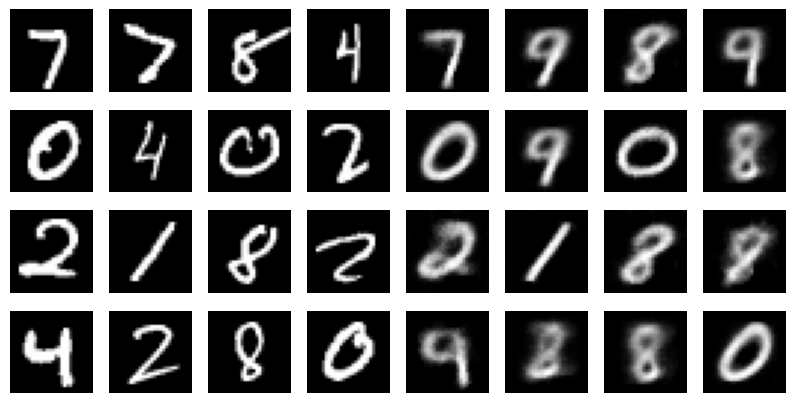

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Set the autoencoder to evaluation mode
autoencoder.eval()

# Get 16 images from the test split
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)
test_images, _ = next(iter(test_loader))
test_images = test_images.to(device)

# Reconstruct the images using the autoencoder
with torch.no_grad():
    reconstructed_images = autoencoder(test_images)

# Plot the original and reconstructed images on a grid
fig, axs = plt.subplots(4, 8, figsize=(10, 5))
for i in range(4):
    for j in range(8):
        if j < 4:
            axs[i, j].imshow(test_images[i*4+j].cpu().numpy().squeeze(), cmap='gray')
        else:
            axs[i, j].imshow(reconstructed_images[i*4+j-4].cpu().numpy().squeeze(), cmap='gray')
        axs[i, j].axis('off')
        
fig.set_label('Original and Reconstructed Images')

plt.show()


### Plot the latent code

Once the autoencoder model is trained, we can use it to compress the MNIST dataset into a latent code. We can then plot the latent code to see how the autoencoder compresses the MNIST dataset. In this case, we use the test split and visualize the latent code distribution.

We can see the same digits tend to cluster in the latent space. This shows that the autoencoder is able to compress the MNIST dataset into a latent code that preserves the structure of the dataset.



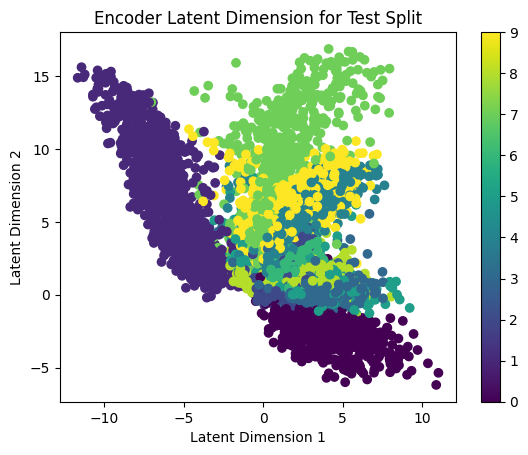

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Set the autoencoder to evaluation mode
autoencoder.eval()

# Get the latent dimension for the test split
with torch.no_grad():
    test_latent = []
    for img, _ in test_dataset:
        img = img.unsqueeze(0).to(device)
        latent = autoencoder.encoder(img)
        test_latent.append(latent.cpu().numpy())
    test_latent = np.concatenate(test_latent)

# Plot the latent dimension
plt.scatter(test_latent[:, 0], test_latent[:, 1], c=test_dataset.targets.numpy())
plt.colorbar()
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Encoder Latent Dimension for Test Split')
plt.show()


### MNIST Image Generation

The decoder is a generative AI model for synthesizing new MNIST images. We can use the decoder to generate new images by sampling the latent code from a uniform distribution (-5,5) for latent dims and passing it to the decoder. We can then plot the generated images to see how the decoder performs.

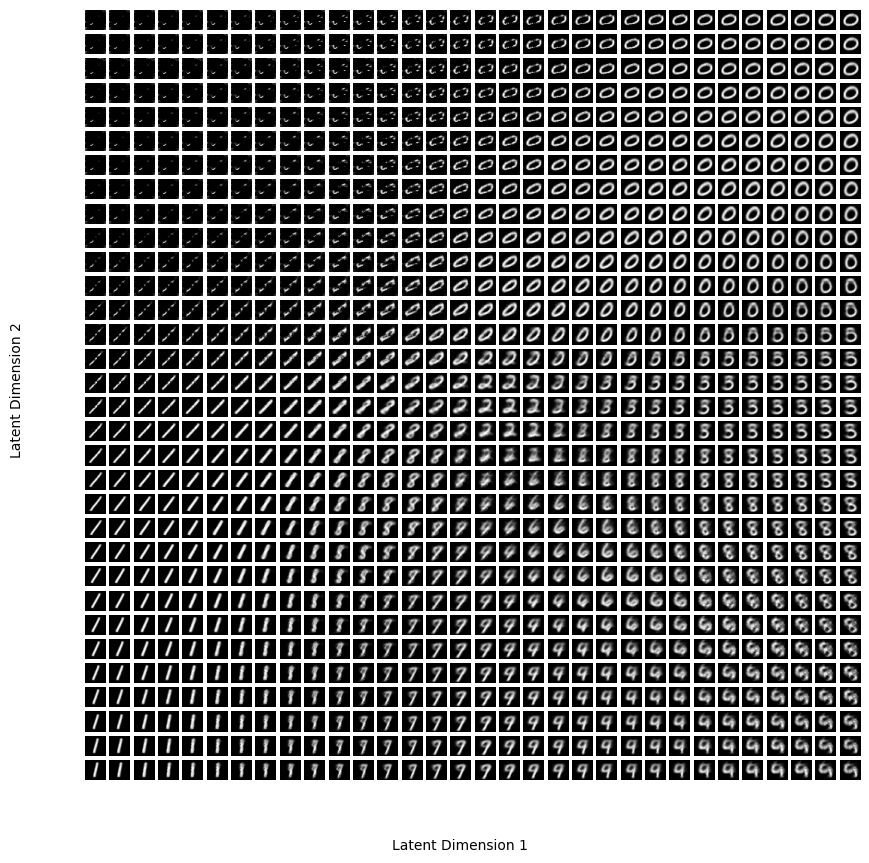

In [14]:
import numpy as np
import matplotlib.pyplot as plt

n_dim = 32

latent_dim = torch.FloatTensor(n_dim*n_dim, 2).to(device)
latent_dim[:, 0] = torch.linspace(-5, 5, n_dim).repeat(n_dim)
latent_dim[:, 1] = torch.linspace(-5, 5, n_dim).unsqueeze(1).repeat(1, n_dim).view(-1)
latent_dim = latent_dim.to(device)

# Generate images from the decoder
with torch.no_grad():
    generated_images = autoencoder.decoder(latent_dim)

# Plot the images as a function of latent dim
fig, axs = plt.subplots(n_dim, n_dim, figsize=(10, 10))
for i in range(n_dim):
    for j in range(n_dim):
        axs[i, j].imshow(generated_images[i*n_dim+j].cpu().numpy().squeeze(), cmap='gray')
        axs[i, j].axis('off')
        
fig.set_label('Generated Images')

fig.text(0.5, 0.04, 'Latent Dimension 1', ha='center')
fig.text(0.05, 0.5, 'Latent Dimension 2', va='center', rotation='vertical')

plt.xlabel('Latent Dimension 1')

plt.show()

### Denoising Autoencoder

We can also use the autoencoder model to denoise images. We can do this by adding noise to the input images and training the model to reconstruct the original images. We can then use the trained model to denoise new images. Below we add noise to the test images and visualize the denoised images.

In [43]:
def train(autoencoder, dataloader, criterion, optimizer, scheduler, device, num_epochs=10):
    # Set the autoencoder to train mode
    autoencoder.train()

    # Train the autoencoder for the specified number of epochs
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (img, _) in enumerate(dataloader):
            img = img.to(device) # Use CUDA if available
            noise_tensor = torch.randn_like(img) * 0.5 + 0.5
            noise_tensor = noise_tensor.to(device)
            noisy_img = img + noise_tensor
            # Clip the noisy_test_image tensor
            noisy_img = torch.clamp(noisy_img, 0, 1)
            recon = autoencoder(noisy_img)
            loss = criterion(recon, img)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(dataloader)
        print('Epoch [{}/{}], Loss: {:.4f}, Learning Rate: {:.6f}'.format(epoch+1, num_epochs, epoch_loss, optimizer.param_groups[0]['lr']))
        scheduler.step()
    
    return autoencoder



In [44]:
# Instantiate a new autoencoder model
denoising_autoencoder = Autoencoder()
denoising_autoencoder.to(device)

# Define the loss function (MSELoss) and the optimizer (Adam)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(denoising_autoencoder.parameters(), lr=0.001)

# Define the learning rate scheduler (CosineAnnealingLR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

print(f"Number of model parameters: {sum(p.numel() for p in denoising_autoencoder.parameters())/1e6:.2f} million")
print(f"Running on: {device}")

train(denoising_autoencoder, train_loader, criterion, optimizer, scheduler, device, num_epochs=10)

Number of model parameters: 0.20 million
Running on: cuda
Epoch [1/10], Loss: 0.0655, Learning Rate: 0.001000
Epoch [2/10], Loss: 0.0508, Learning Rate: 0.000976
Epoch [3/10], Loss: 0.0479, Learning Rate: 0.000905
Epoch [4/10], Loss: 0.0465, Learning Rate: 0.000794
Epoch [5/10], Loss: 0.0455, Learning Rate: 0.000655
Epoch [6/10], Loss: 0.0448, Learning Rate: 0.000500
Epoch [7/10], Loss: 0.0443, Learning Rate: 0.000345
Epoch [8/10], Loss: 0.0439, Learning Rate: 0.000206
Epoch [9/10], Loss: 0.0437, Learning Rate: 0.000095
Epoch [10/10], Loss: 0.0435, Learning Rate: 0.000024


Autoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc): Linear(in_features=2048, out_features=2, bias=True)
  )
  (bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (decoder): Decoder(
    (fc): Linear(in_features=2, out_features=2048, bias=True)
    (conv1): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv3): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

### Generate Noised Images from Test Split

Sample 16 images from the test split and visualize the noised images.

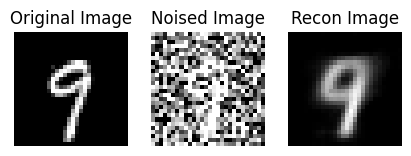

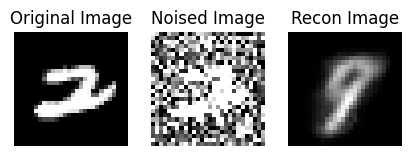

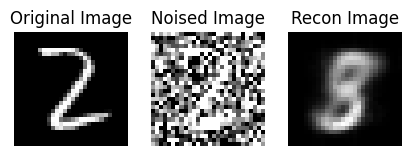

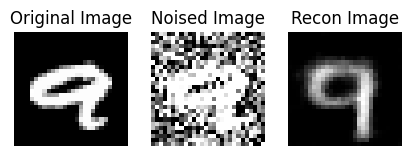

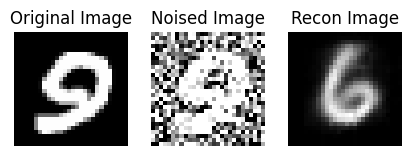

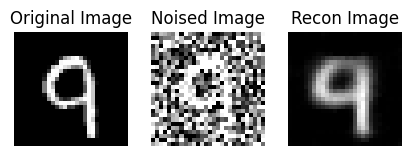

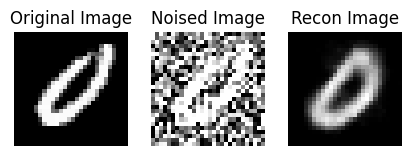

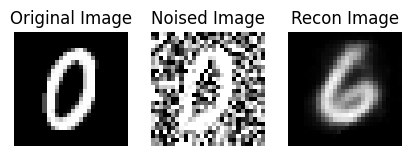

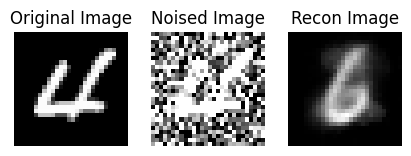

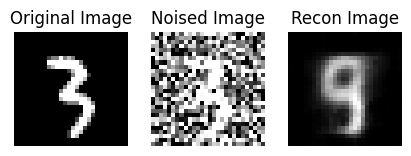

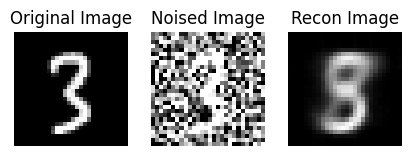

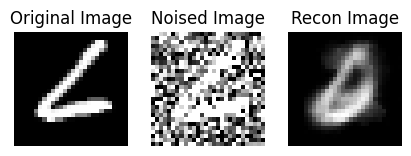

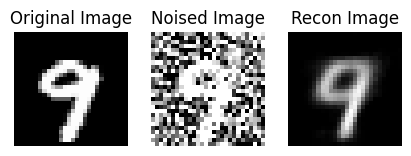

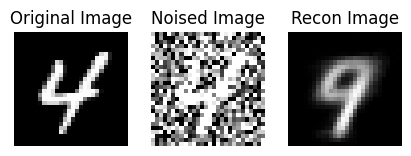

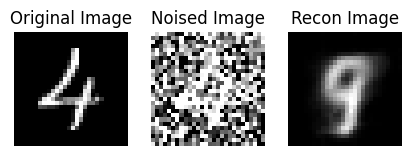

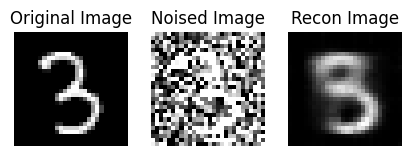

In [45]:

# Set the autoencoder to evaluation mode
denoising_autoencoder.eval()

# Get the test images
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)
for i, (test_image, _) in enumerate(test_loader):
    test_image = test_image.to(device)
    
    noise_tensor = torch.randn_like(test_image) * 0.5 + 0.5

    noise_tensor = noise_tensor.to(device)
    noisy_test_image = test_image + noise_tensor
    
    # Clip the noisy_test_image tensor
    noisy_test_image = torch.clamp(noisy_test_image, 0, 1)
    
    # Reconstruct the image using the autoencoder
    with torch.no_grad():
        reconstructed_image = denoising_autoencoder(noisy_test_image)
    
    # Plot the original and reconstructed images side by side
    fig, axs = plt.subplots(1, 3, figsize=(5, 2))
    axs[0].imshow(test_image.cpu().numpy().squeeze(), cmap='gray')
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    
    axs[1].imshow(noisy_test_image.cpu().numpy().squeeze(), cmap='gray')
    axs[1].set_title('Noised Image')
    axs[1].axis('off')
    
    axs[2].imshow(reconstructed_image.cpu().numpy().squeeze(), cmap='gray')
    axs[2].set_title('Recon Image')
    axs[2].axis('off')
    plt.show()
    
    # Stop after 16 images
    if i == 15:
        break



(16, 28, 28)


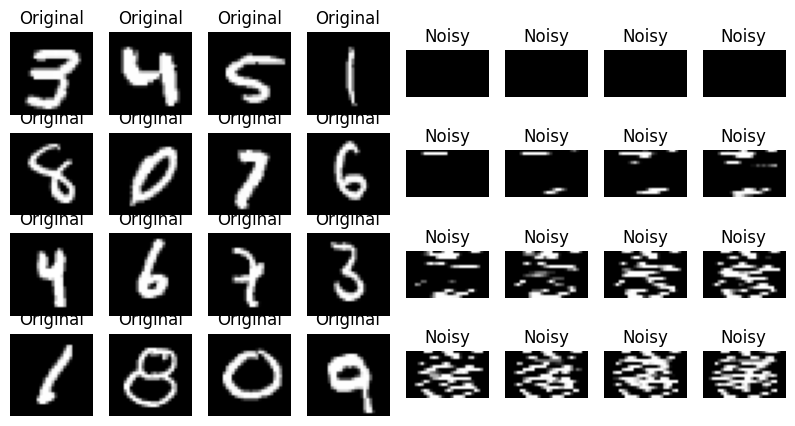

In [46]:
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

# Set the autoencoder to evaluation mode
new_autoencoder.eval()

# Get 16 images from the test split
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)
test_images, _ = next(iter(test_loader))
test_images = test_images.to(device)


to_pil = ToPILImage()

pil_images = []
for img in test_images:
    pil_images.append(to_pil(img.cpu()))

pil_images_np = np.array([np.array(img) for img in pil_images])
print(pil_images_np.shape)

# Add salt and pepper noise to the test images
noisy_images = transform(pil_images_np)
noisy_images = noisy_images.unsqueeze(1).to(device)

# Reconstruct the images using the autoencoder
with torch.no_grad():
    reconstructed_images = new_autoencoder(noisy_images)

# Plot the original, noisy, and reconstructed images on a grid
fig, axs = plt.subplots(4, 8, figsize=(10, 5))
for i in range(4):
    for j in range(8):
        if j < 4:
            axs[i, j].imshow(test_images[i*4+j].cpu().numpy().squeeze(), cmap='gray')
            axs[i, j].set_title('Original')
        elif j < 8:
            axs[i, j].imshow(noisy_images[i*4+j-4].cpu().numpy().squeeze(), cmap='gray')
            axs[i, j].set_title('Noisy')
        else:
            axs[i, j].imshow(reconstructed_images[i*4+j-8].cpu().numpy().squeeze(), cmap='gray')
            axs[i, j].set_title('Reconstructed')
        axs[i, j].axis('off')
        
fig.set_label('Original, Noisy, and Reconstructed Images')

plt.show()
